The aim of this notebook is to forecast baggage complaints over time using two different models: XGBoost and SARIMA. We will compare the results of these two algorithms to determine which one provides better forecasts. The dataset used for this analysis is sourced from Kaggle. This is a time series problem, and we will begin by loading and exploring the dataset, followed by model training and evaluation.

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 5
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
from datetime import datetime
import utils

In [126]:
ROOT_DIR = './data/'
TARGET_TEST_CUTOFF_DATE = '2008-01-01'


In [127]:

df = pd.read_csv(ROOT_DIR + 'baggagecomplaints.csv', index_col='Date',parse_dates=True)


/tmp/ipykernel_6537/1213201793.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [128]:
df.head()

,Airline,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
Date,,,,,,,
2004-01-01,American Eagle,1,2004,12502,38276,2481,992360
2004-02-01,American Eagle,2,2004,8977,35762,886,1060618
2004-03-01,American Eagle,3,2004,10289,39445,1346,1227469
2004-04-01,American Eagle,4,2004,8095,38982,755,1234451
2004-05-01,American Eagle,5,2004,10618,40422,2206,1267581


In [129]:
df['Airline'].value_counts()
df['Baggage %'] = 100* df['Baggage']/df['Enplaned']
df.rename(columns={'Enplaned': 'Enplaned passengers'}, inplace=True)

In [130]:
df.head()

,Airline,Month,Year,Baggage,Scheduled,Cancelled,Enplaned passengers,Baggage %
Date,,,,,,,,
2004-01-01,American Eagle,1,2004,12502,38276,2481,992360,1.259825
2004-02-01,American Eagle,2,2004,8977,35762,886,1060618,0.846393
2004-03-01,American Eagle,3,2004,10289,39445,1346,1227469,0.838229
2004-04-01,American Eagle,4,2004,8095,38982,755,1234451,0.655757
2004-05-01,American Eagle,5,2004,10618,40422,2206,1267581,0.837659


In [131]:
# we split our data into 3 dataframe, one for each company
grouped = df.groupby(df.Airline)
dfAmerican = grouped.get_group("American Eagle")
dfHawaiian = grouped.get_group("Hawaiian")
dfUnited = grouped.get_group("United")
print(len(dfAmerican))
print(len(dfHawaiian))
print(len(dfUnited))

84
84
84


In [132]:
dfAmerican.index.freq = 'MS' #Month Start frequency
dfUnited.index.freq = 'MS'
dfHawaiian.index.freq = 'MS'


In [133]:
dfAmerican.head()


,Airline,Month,Year,Baggage,Scheduled,Cancelled,Enplaned passengers,Baggage %
Date,,,,,,,,
2004-01-01,American Eagle,1,2004,12502,38276,2481,992360,1.259825
2004-02-01,American Eagle,2,2004,8977,35762,886,1060618,0.846393
2004-03-01,American Eagle,3,2004,10289,39445,1346,1227469,0.838229
2004-04-01,American Eagle,4,2004,8095,38982,755,1234451,0.655757
2004-05-01,American Eagle,5,2004,10618,40422,2206,1267581,0.837659


In [134]:
dfUnited.head()

,Airline,Month,Year,Baggage,Scheduled,Cancelled,Enplaned passengers,Baggage %
Date,,,,,,,,
2004-01-01,United,1,2004,25015,45809,1017,4434315,0.564123
2004-02-01,United,2,2004,16660,42675,312,4458657,0.373655
2004-03-01,United,3,2004,19318,46512,321,5302929,0.364289
2004-04-01,United,4,2004,15638,45309,162,5288871,0.295677
2004-05-01,United,5,2004,19302,46630,652,5408451,0.356886


In [135]:
dfHawaiian.head()


,Airline,Month,Year,Baggage,Scheduled,Cancelled,Enplaned passengers,Baggage %
Date,,,,,,,,
2004-01-01,Hawaiian,1,2004,1717,3879,28,461353,0.372166
2004-02-01,Hawaiian,2,2004,1599,3743,34,446091,0.358447
2004-03-01,Hawaiian,3,2004,1327,4052,16,501722,0.264489
2004-04-01,Hawaiian,4,2004,1350,3918,8,466457,0.289416
2004-05-01,Hawaiian,5,2004,1304,3976,8,460080,0.283429


In [136]:
df.head()

,Airline,Month,Year,Baggage,Scheduled,Cancelled,Enplaned passengers,Baggage %
Date,,,,,,,,
2004-01-01,American Eagle,1,2004,12502,38276,2481,992360,1.259825
2004-02-01,American Eagle,2,2004,8977,35762,886,1060618,0.846393
2004-03-01,American Eagle,3,2004,10289,39445,1346,1227469,0.838229
2004-04-01,American Eagle,4,2004,8095,38982,755,1234451,0.655757
2004-05-01,American Eagle,5,2004,10618,40422,2206,1267581,0.837659


We plot the 3 dataframes to see which company has more baggage complaint

In [137]:
fig = px.line(df, y="Baggage", color="Airline", color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title='Bagages complaints for each company'
)
fig.show()

United Airlines has the most complaints about mishandled baggage in almost all of the months in the data set; Hawaiian Airlines has the fewest number of complaints in all months.

In [138]:
newframe = df.groupby('Airline').describe()[['Scheduled', 'Enplaned passengers']]
newframe = newframe.drop(['count','std','min','25%','50%','75%','max'], axis = 1, level = 1)
newframe = newframe.round(decimals=2)
newframe

,Scheduled,Enplaned passengers
,mean,mean
Airline,,
American Eagle,41314.05,1396725.55
Hawaiian,4844.68,594174.17
United,38225.30,4620712.26



United Airlines is a much bigger airline, which shows the average number of scheduled flights and enplaned passengers by airline. United handles more than three times the number of passengers than American Eagle on average, and almost eight times more than Hawaiian. So United has more opportunities to mishandle luggage because it handles more luggage.


In [139]:


newframe = df.groupby('Airline').describe()['Baggage %']
newframe = newframe.drop(['count','std','min','25%','50%','75%','max'], axis = 1)
newframe = newframe.round(decimals=3)
newframe



,mean
Airline,
American Eagle,1.033
Hawaiian,0.277
United,0.464




We see that American Eagle has the highest rate of baggage complaints when adjusted for number of enplaned passengers.

Plotting the Baggage % on a time series plot allows us to see changes over time.


In [140]:


fig = px.line(df, y="Baggage %", color="Airline", color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title=''
)
fig.show()





So we see that baggage complaint rates from American Eagle and United passengers increased through 2006 and began declining thereafter.

The time series for Hawaiian passengers is relatively flat compared to American Eagle and United, so it’s difficult to detect a pattern over time.


In [141]:



fig = px.line(df, y="Baggage %", color="Airline", facet_col="Airline", color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(
    mirror=True,
    ticks=None,
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title='',
    matches=None,
    visible=False
)
fig.show()



We isolated the data for the Hawaiian flights. Complaint rates for Hawaiian passengers began to drop in the summer of 2008 until fall of 2010, after which the rate of complaints returned to historical levels.
.

The pattern of spikes and dips indicates that changes in the rate of baggage complaints may have a seasonal component.


In [142]:


Baggage_mean = df.groupby(["Airline","Month"]).mean(['Baggage %'])
Baggage_mean = Baggage_mean.reset_index()



We plotted the average Baggage % by month for the three airlines to investigate this further. \ Average rates are highest in December and January and in the summer months, and lowest in the spring and late fall. Interestingly, all three airlines seem to follow the same general pattern.


In [143]:
fig = px.line(Baggage_mean, x='Month', y='Baggage %', color="Airline", facet_col="Airline", color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(plot_bgcolor='white')
fig.update_yaxes(
    mirror=True,
    ticks=None,
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    title='',
    matches=None,
    visible=False
)
fig.update_xaxes(
    dtick = 1
)
fig.show()


In [144]:


Baggage_mean = df.groupby(["Date"]).mean(['Baggage'])
Baggage_mean = Baggage_mean.drop(['Month','Year','Scheduled','Cancelled','Enplaned passengers','Baggage %'], axis = 1)
df = Baggage_mean
df.index = pd.to_datetime(df.index)



In [145]:
df.tail()

,Baggage
Date,
2010-08-01,8321.666667
2010-09-01,6557.000000
2010-10-01,6776.000000
2010-11-01,6228.000000
2010-12-01,9548.666667


We use Seasonal Decompose of Time series to understand the underlying structure and identify patterns, trends and seasonality in the data

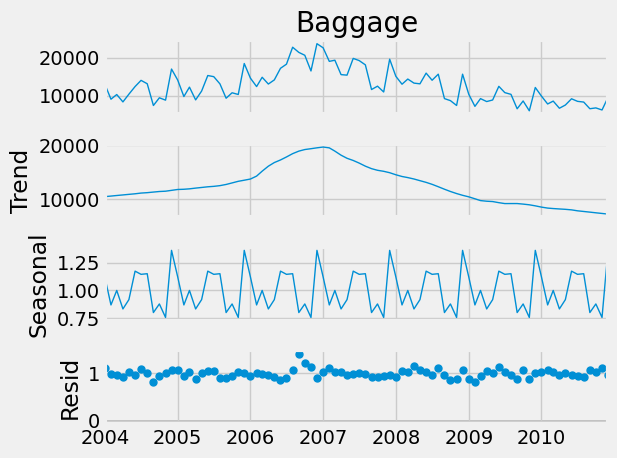

In [146]:
from statsmodels.tsa.seasonal import seasonal_decompose

#decompose the time serie into three main compoonents : trend, seasonal and residual
mult_decomp = seasonal_decompose(df['Baggage'], model='multiplicative', extrapolate_trend='freq', period= 12)
mult_decomp.plot()
plt.show()

In [147]:
train = df.loc[df.index < TARGET_TEST_CUTOFF_DATE]
test = df.loc[df.index >= TARGET_TEST_CUTOFF_DATE]

## Plot the Train / Test Split data

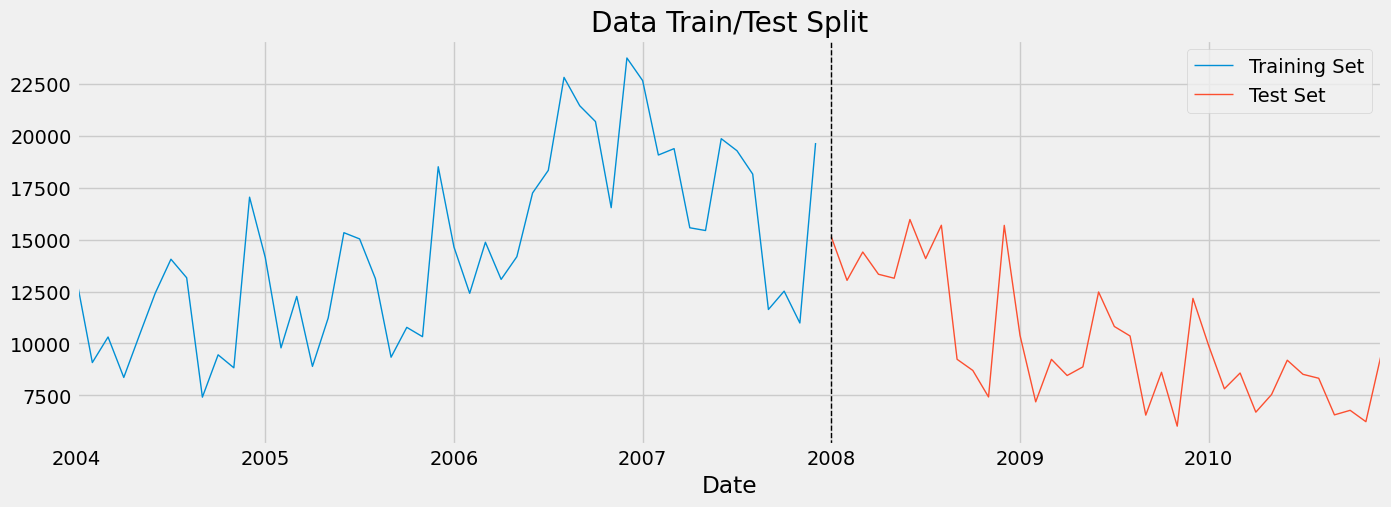

In [148]:
utils.plot_train_test_split(df, TARGET_TEST_CUTOFF_DATE)

### Just want see how a monthly data looks like

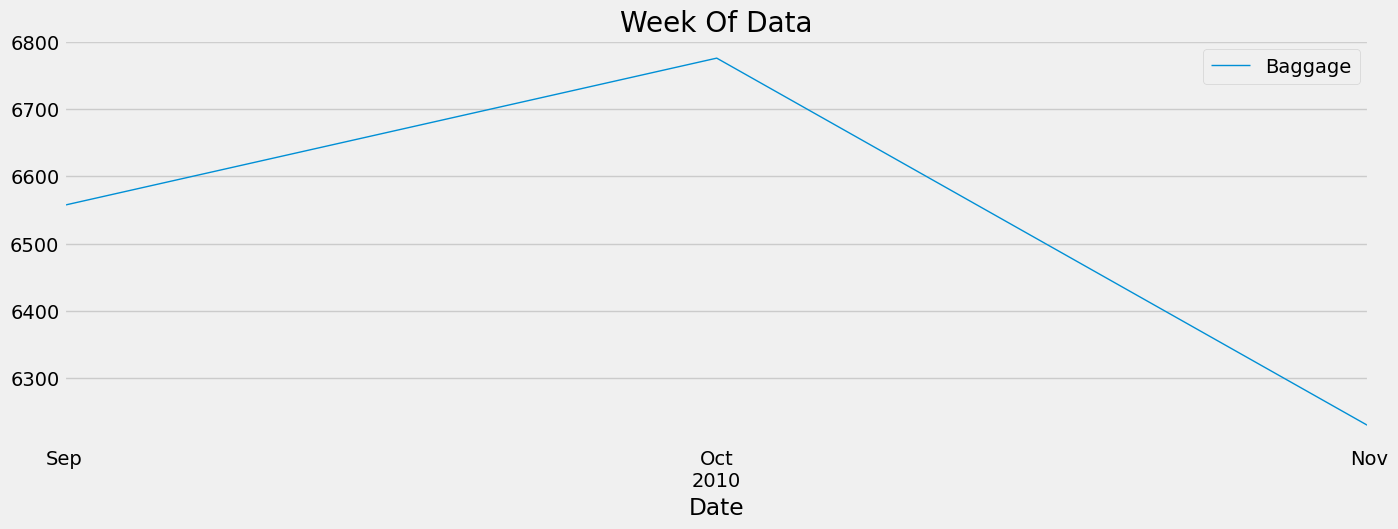

In [149]:
utils.plot_week_of_data(df, '2010-08-01', '2010-12-01')


# From DataTime column of the original DF create features for TIme Series

In [150]:
df = utils.create_time_series_features(df)


# Visualize our Feature / Target Relationship

In [151]:
df.head()

,Baggage,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2004-01-01,13078.000000,3,1,1,2004,1,1,1
2004-02-01,9078.666667,6,1,2,2004,32,1,5
2004-03-01,10311.333333,0,1,3,2004,61,1,10
2004-04-01,8361.000000,3,2,4,2004,92,1,14
2004-05-01,10408.000000,5,2,5,2004,122,1,18


/tmp/ipykernel_6537/3949041605.py:28: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



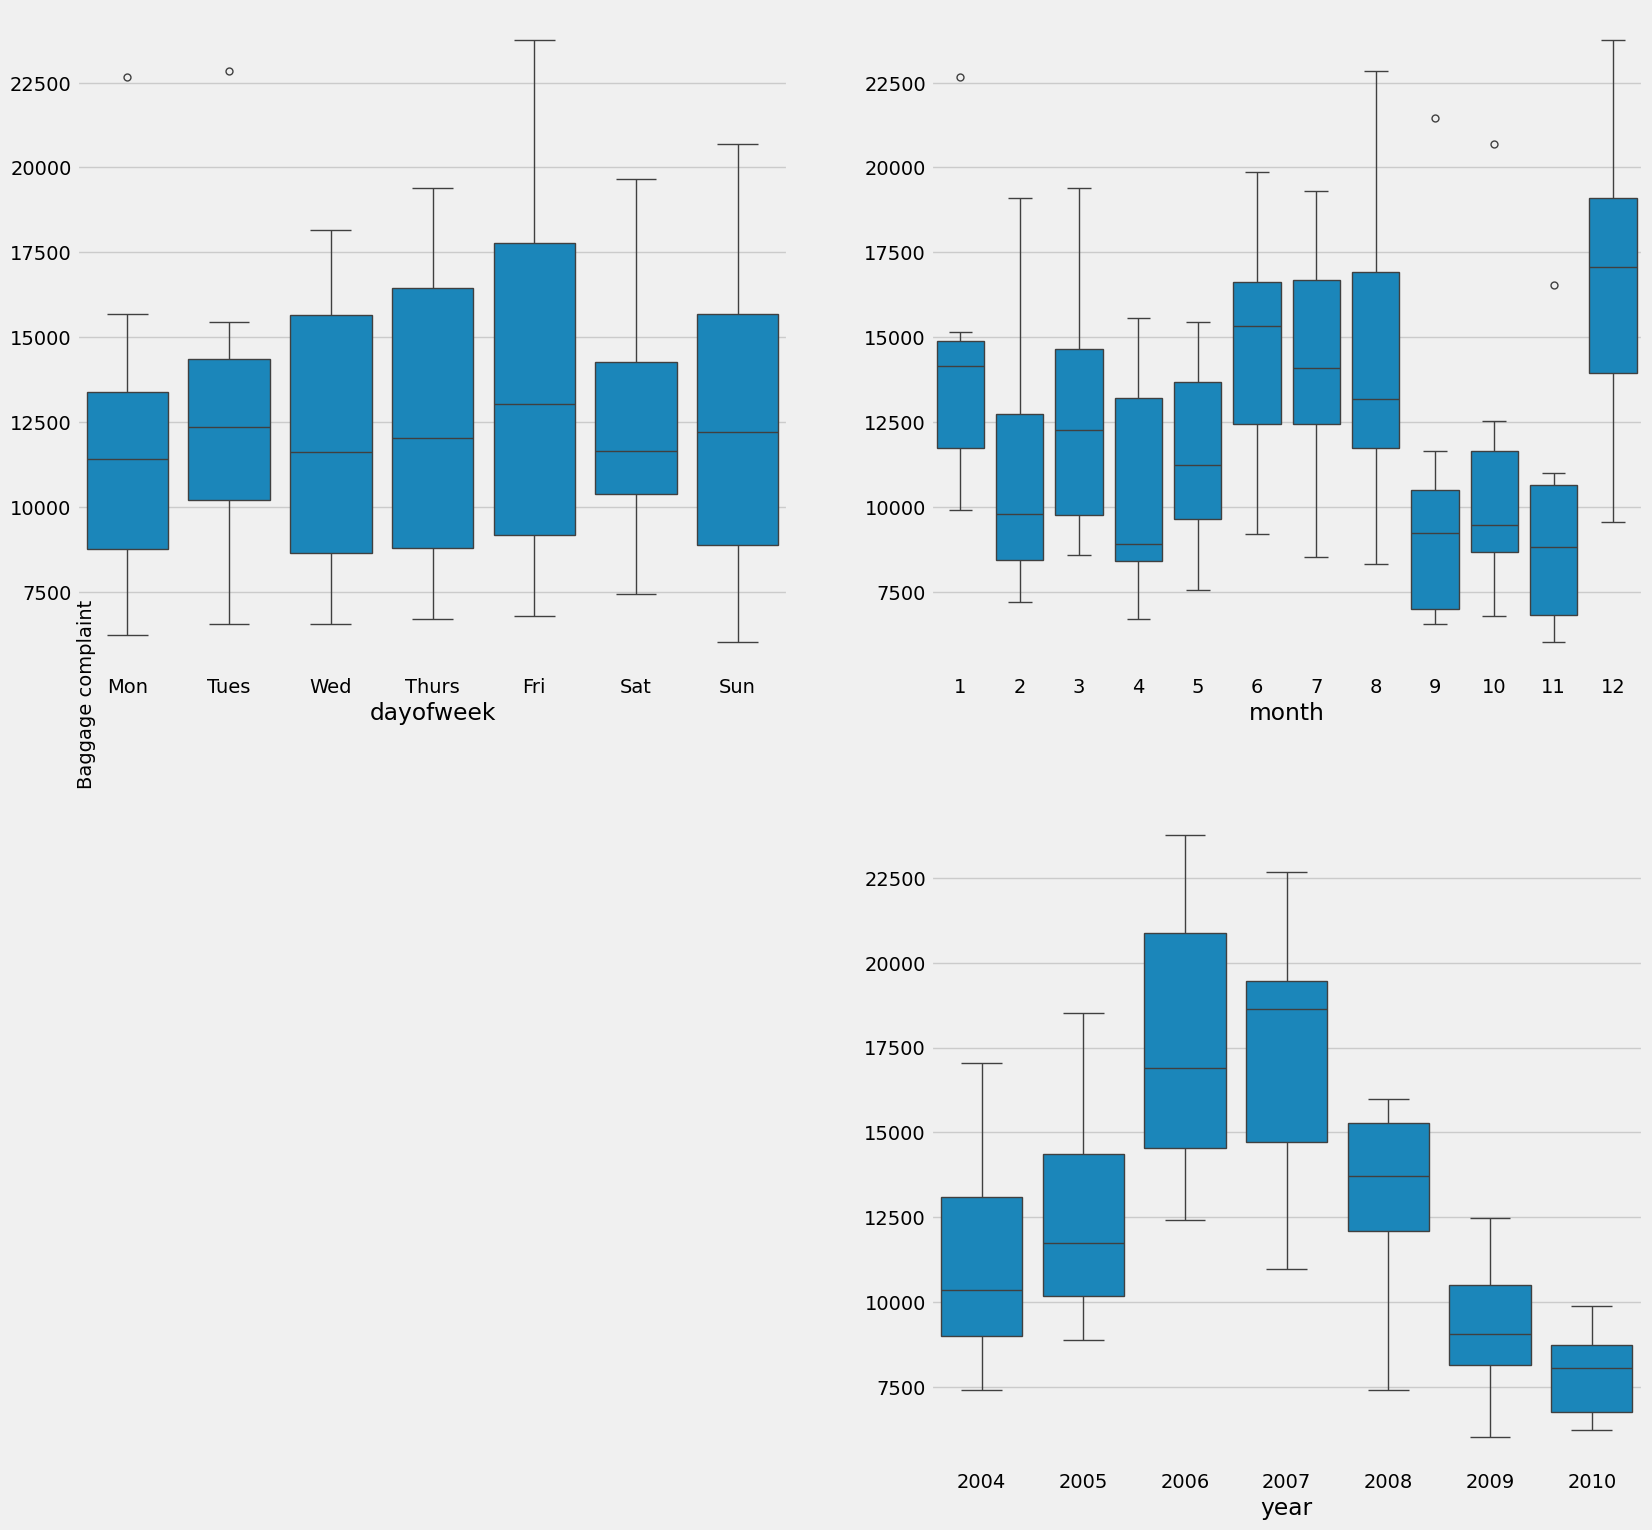

In [152]:
def plot_time_series(df, dependent_var):
    """
    This function generates a 2x2 grid of boxplots to visualize the time series data.
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the time series data.
        
    dependent_var : str
        The column name of the dependent variable in the dataframe.
        
    Returns
    -------
    None
    """
    
    # Assert if the required columns are present in the dataframe
    assert 'dayofweek' in df.columns, "Input dataframe must have a 'dayofweek' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"
    
    fig, axes = plt.subplots(2, 2, figsize=(18,18))
    
    # Day of Week
    dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
    g = sns.boxplot(x=df.dayofweek, y=df[dependent_var], ax=axes[0][0])
    g.set_xticklabels(dow_labels)
    g.set_ylabel('')
    
    # Month of Year
    g = sns.boxplot(x=df.month, y=df[dependent_var], ax=axes[0][1])
    g.set_ylabel('')
    
    # Year
    g = sns.boxplot(x=df.year, y=df[dependent_var], ax=axes[1][1])
    g.set_ylabel('')
    
    # Remove the empty subplot
    fig.delaxes(axes[1][0])

    # Set the title for the y-axis
    fig.text(0.08, 0.5, 'Baggage complaint', va='center', rotation='vertical')
    
    # Display the plot
    plt.show()

plot_time_series(df, 'Baggage')

In [153]:
df_dup = df.copy()
years_months = df_dup.groupby(['year', 'month']).mean().reset_index()
years_months.head()

,year,month,Baggage,dayofweek,quarter,dayofyear,dayofmonth,weekofyear
0,2004,1,13078.000000,3.0,1.0,1.0,1.0,1.0
1,2004,2,9078.666667,6.0,1.0,32.0,1.0,5.0
2,2004,3,10311.333333,0.0,1.0,61.0,1.0,10.0
3,2004,4,8361.000000,3.0,2.0,92.0,1.0,14.0
4,2004,5,10408.000000,5.0,2.0,122.0,1.0,18.0


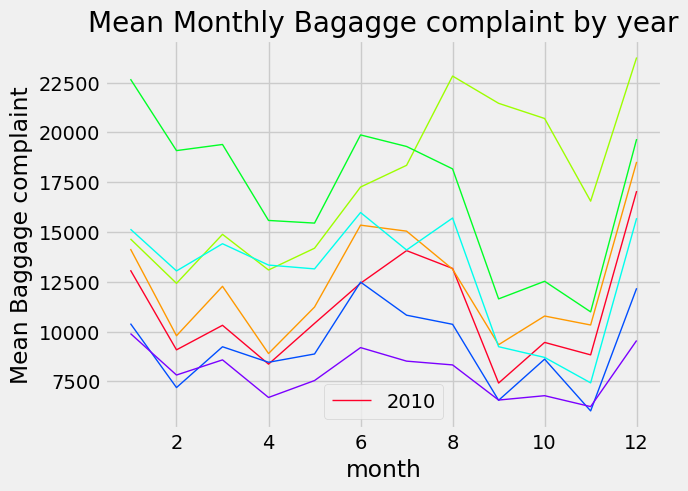

In [154]:
import matplotlib.pyplot as plt

def plot_monthly_consumption(df, dependent_var):
    """
    This function generates a line plot of the mean monthly baggage complaints for each year.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the time series data.
        
    dependent_var : str
        The column name of the dependent variable in the dataframe.
        
    Returns
    -------
    None
    """
    
    
    # Assert if the required columns are present in the dataframe
    assert 'year' in df.columns, "Input dataframe must have a 'year' column"
    assert 'month' in df.columns, "Input dataframe must have a 'month' column"
    assert dependent_var in df.columns, f"Input dataframe must have a '{dependent_var}' column"

    df_copy = df.copy()

    # Group data by year and month, and compute the mean for each group
    year_group = df_copy.groupby(['year', 'month']).mean().reset_index()
    
    # Get the unique years from the dataframe
    years = df_copy['year'].unique()
    NUM_COLORS = len(years)

    # Prepare color mapping
    cm = plt.get_cmap('gist_rainbow')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    # Plot the mean monthly consumption for each year
    for i, y in enumerate(years):
        df_copy = year_group[year_group['year'] == y]
        plt.plot(df_copy['month'], df_copy[dependent_var], linewidth=1, markersize=5)
    
    plt.title('Mean Monthly Bagagge complaint by year')
    plt.xlabel('month')
    plt.ylabel('Mean Baggage complaint')
    plt.legend(df_copy.year.unique())
    plt.show()

plot_monthly_consumption(df, 'Baggage')


In [155]:
# !pip install statsmodels

Feature engineering part

In [156]:
train.head()

,Baggage
Date,
2004-01-01,13078.000000
2004-02-01,9078.666667
2004-03-01,10311.333333
2004-04-01,8361.000000
2004-05-01,10408.000000


In [157]:
train = utils.create_time_series_features(train)
test = utils.create_time_series_features(test)
train.head(2)

,Baggage,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2004-01-01,13078.000000,3,1,1,2004,1,1,1
2004-02-01,9078.666667,6,1,2,2004,32,1,5


In [158]:
# for XGBoost model
train['weekofyear'] = train['weekofyear'].astype('int32')
test['weekofyear'] = test['weekofyear'].astype('int32')

In [159]:
# Feature and target variables
time_series_features = ['dayofyear', 'dayofweek', 'weekofyear', 'quarter', 'month', 'year']
time_series_target = 'Baggage'

X_train = train[time_series_features]
y_train = train[time_series_target]

X_test = test[time_series_features]
y_test = test[time_series_target]

In [160]:
X_train.head(2)


,dayofyear,dayofweek,weekofyear,quarter,month,year
Date,,,,,,
2004-01-01,1,3,1,1,1,2004
2004-02-01,32,6,5,1,2,2004


In [161]:
y_test.head(2)

Date
2008-01-01    15138.333333
2008-02-01    13042.333333
Name: Baggage, dtype: float64

In [162]:
model = utils.train_xgb_regressor(X_train, y_train, X_test, y_test, use_gpu=False)

[0]	validation_0-rmse:15000.05818	validation_1-rmse:10375.84548
[100]	validation_0-rmse:6548.18443	validation_1-rmse:2968.73603
[146]	validation_0-rmse:4775.42896	validation_1-rmse:3743.97250


/home/amine/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning:

[15:30:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.



Let's plot feature importance representation

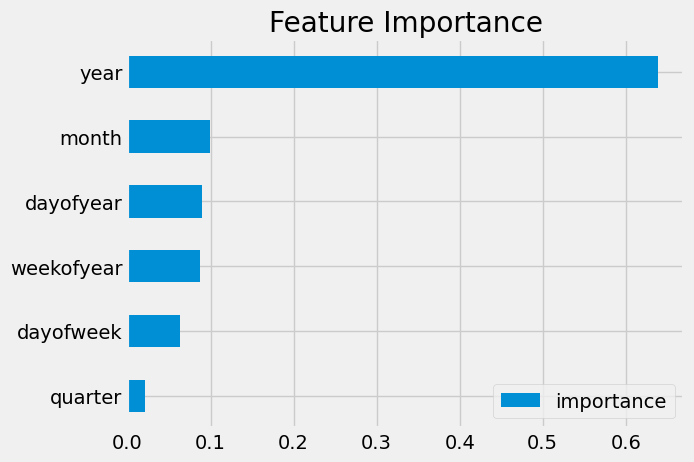

In [163]:
utils.plot_feature_importance(model)


In [164]:
test['prediction'] = model.predict(X_test)

df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

df.tail(20)

,Baggage,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Date,,,,,,,,,
2009-05-01,8871.000000,4,2,5,2009,121,1,18,9903.638672
2009-06-01,12481.666667,0,2,6,2009,152,1,23,9969.486328
2009-07-01,10819.000000,2,3,7,2009,182,1,27,10180.737305
2009-08-01,10360.666667,5,3,8,2009,213,1,31,10180.737305
2009-09-01,6545.000000,1,3,9,2009,244,1,36,10021.761719
2009-10-01,8610.666667,3,4,10,2009,274,1,40,10000.538086
2009-11-01,6011.666667,6,4,11,2009,305,1,44,9996.827148
2009-12-01,12173.333333,1,4,12,2009,335,1,49,10256.865234
2010-01-01,9897.333333,4,1,1,2010,1,1,53,10101.219727


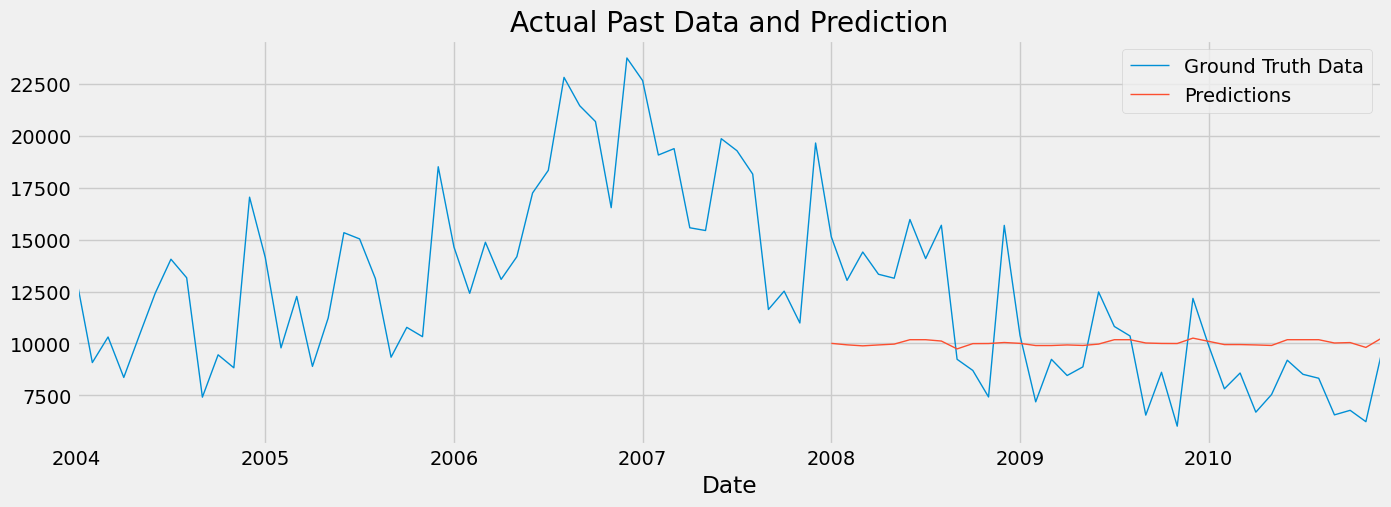

In [165]:

ax = df[['Baggage']].plot(figsize=(15, 5))

df['prediction'].plot(ax=ax, style='-')
plt.legend(['Ground Truth Data', 'Predictions'])
ax.set_title('Actual Past Data and Prediction')
plt.show()

The model is not learning the pattern effectively


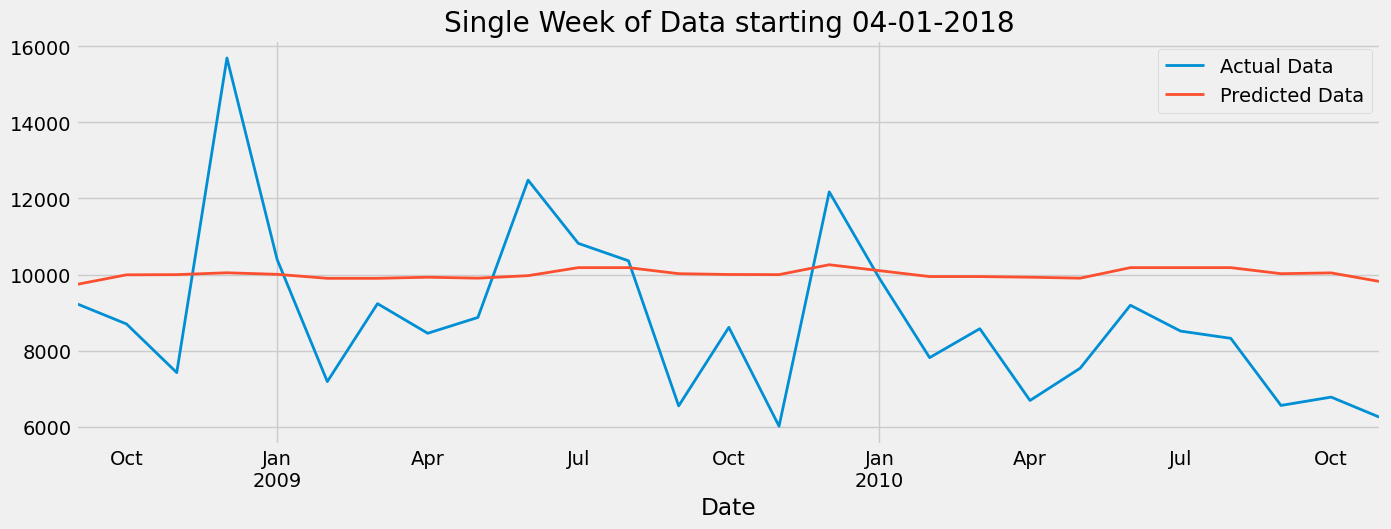

In [166]:
# select data within a specific date range 2010-08-01', '2010-12-01
data = df.loc[(df.index > '2008-08-01') & (df.index < '2010-12-01')]

# plot the actual and predicted data
ax = data['Baggage'].plot(figsize=(15, 5), title='Single Week of Data starting 04-01-2018', linewidth=2, markersize=5)

data['prediction'].plot(style='-', linewidth=2, markersize=5)

plt.legend(['Actual Data', 'Predicted Data'])
plt.show()


In [167]:
score = np.sqrt(mean_squared_error(test['Baggage'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 2962.87


## Sort Predictions by Error values


In [168]:
test['error'] = np.abs(test[time_series_target] - test['prediction'])

test['date'] = test.index.date

test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

date
2008-06-01    5795.262695
2008-12-01    5648.052409
2008-08-01    5582.307292
2008-01-01    5133.493490
2008-03-01    4523.807943
2009-11-01    3985.160482
2008-07-01    3912.596029
2010-11-01    3580.662109
2009-09-01    3476.761719
2010-09-01    3464.761719
Name: error, dtype: float64

Test with SARIMA Model

In [169]:
from pmdarima import auto_arima                         

In [170]:
auto_arima(Baggage_mean['Baggage'], seasonal=True, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   84
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -755.267
Date:                              Sun, 28 Jul 2024   AIC                           1528.534
Time:                                      15:30:57   BIC                           1550.303
Sample:                                  01-01-2004   HQIC                          1537.280
                                       - 12-01-2010                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    115.2815    133.936      0.861      0.389    -147.228     377.791
ar.L1          0.4222      0.247      1.712      0.087      -0.061       0.906
ar.L2         -0.6752      0.171     -3.940      0.000      -1.011      -0.339
ar.L3         -0.2567      0.138     -1.859      0.063      -0.527       0.014
ma.L1         -0.6554      0.233     -2.813      0.005      -1.112      -0.199
ma.L2          0.6907      0.215      3.219      0.001       0.270       1.111
ar.S.L12       0.7742      0.138      5.613      0.000       0.504       1.045
ma.S.L12      -0.3359      0.201     -1.670      0.095      -0.730       0.058
sigma2      4.455e+06      0.002   1.98e+09      0.000    4.46e+06    4.46e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                 8.40
Prob(Q):                              0.36   Prob(JB):                         0.02
Heteroskedasticity (H):               0.29   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.03e+25. Standard errors may be unstable.
"""

In [171]:
train = Baggage_mean.iloc[:len(Baggage_mean)-12]
test = Baggage_mean.iloc[len(Baggage_mean)-12:]



In [172]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [173]:
model = SARIMAX(train['Baggage'], order=(3, 1, 2), seasonal_order=(1, 0, [1], 12))
results = model.fit()
results.summary()

/home/amine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/amine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/amine/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/amine/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25893D+00    |proj g|=  3.98851D-01

At iterate    5    f=  9.13381D+00    |proj g|=  6.28843D-02

At iterate   10    f=  9.09779D+00    |proj g|=  1.39622D-02

At iterate   15    f=  9.09732D+00    |proj g|=  1.60720D-03

At iterate   20    f=  9.09717D+00    |proj g|=  1.34021D-03

At iterate   25    f=  9.09716D+00    |proj g|=  1.77262D-04

At iterate   30    f=  9.09716D+00    |proj g|=  5.54281D-04

At iterate   35    f=  9.09699D+00    |proj g|=  7.27319D-03

At iterate   40    f=  9.07812D+00    |proj g|=  7.31519D-02

At iterate   45    f=  9.05379D+00    |proj g|=  3.59798D-02

At iterate   50    f=  9.04981D+00    |proj g|=  4.52160D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/amine/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                              Baggage   No. Observations:                   72
Model:             SARIMAX(3, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -651.586
Date:                              Sun, 28 Jul 2024   AIC                           1319.172
Time:                                      15:30:58   BIC                           1337.273
Sample:                                  01-01-2004   HQIC                          1326.370
                                       - 12-01-2009                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5346      0.265      2.018      0.044       0.015       1.054
ar.L2         -0.7011      0.183     -3.839      0.000      -1.059      -0.343
ar.L3         -0.2071      0.185     -1.122      0.262      -0.569       0.155
ma.L1         -0.7776      0.226     -3.445      0.001      -1.220      -0.335
ma.L2          0.7039      0.209      3.361      0.001       0.293       1.114
ar.S.L12       0.9713      0.058     16.685      0.000       0.857       1.085
ma.S.L12      -0.7706      0.198     -3.882      0.000      -1.160      -0.382
sigma2      4.554e+06   3.05e-08   1.49e+14      0.000    4.55e+06    4.55e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):                 3.84
Prob(Q):                              0.26   Prob(JB):                         0.15
Heteroskedasticity (H):               0.36   Skew:                             0.36
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+30. Standard errors may be unstable.
"""

In [174]:
start = len(train)
end = len(train) + len(test) - 1



In [175]:
predictions = results.predict(start, end, typ='levels').rename('SARIMA Test Predictions')

/home/amine/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



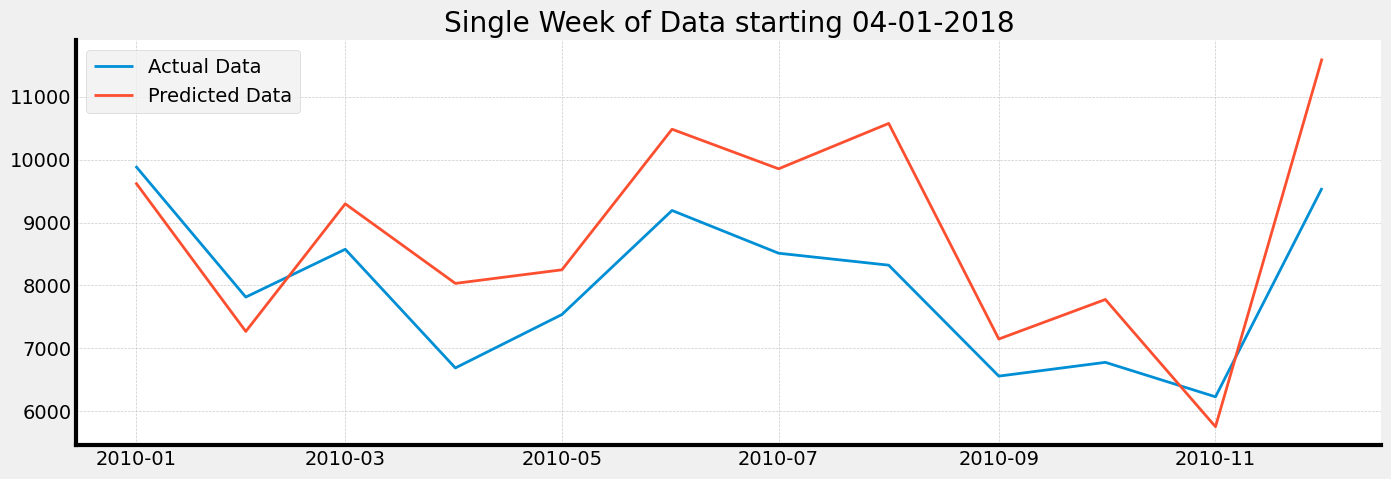

In [183]:
import matplotlib.pyplot as plt

# Assuming `test` contains the test set actual values and `predictions` contains the predicted values
plt.figure(figsize=(15, 5))

# Plot the actual data
plt.plot(test.index, test['Baggage'], label='Actual Data', linewidth=2)

# Plot the predicted data
plt.plot(test.index, predictions, label='Predicted Data', linewidth=2)

# Set the title and legend
plt.title('Single Week of Data starting 04-01-2018')
plt.legend()

# Set the background color to white
plt.gca().set_facecolor('white')

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set the axis line colors and ticks
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')

plt.show()




In [177]:
error = mean_squared_error(test['Baggage'], predictions)
print(f'RMSE Error: {error}')


RMSE Error: 1464772.3889797006


In [178]:
Baggage_mean.describe()

,Baggage
count,84.000000
mean,12613.507937
std,4396.642525
min,6011.666667
25%,9032.416667
50%,12344.166667
75%,15366.666667
max,23763.666667


In [179]:
model = SARIMAX(Baggage_mean['Baggage'], order=(3, 1, 2), seasonal_order=(1, 0, [1], 12))
results = model.fit()
forecast = results.predict(start=len(Baggage_mean), end=len(Baggage_mean)+11, type='levels').rename('SARIMA Forecast')



/home/amine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/home/amine/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13998D+00    |proj g|=  1.82096D-01

At iterate    5    f=  9.06729D+00    |proj g|=  1.39206D-02

At iterate   10    f=  9.05668D+00    |proj g|=  2.84862D-02

At iterate   15    f=  9.04839D+00    |proj g|=  8.70642D-02

At iterate   20    f=  9.04668D+00    |proj g|=  8.27074D-03

At iterate   25    f=  9.04282D+00    |proj g|=  2.01664D-02

At iterate   30    f=  9.04270D+00    |proj g|=  5.21844D-04

At iterate   35    f=  9.04269D+00    |proj g|=  1.50002D-04

At iterate   40    f=  9.04269D+00    |proj g|=  8.91016D-04

At iterate   45    f=  9.04266D+00    |proj g|=  2.32485D-03

At iterate   50    f=  9.04199D+00    |proj g|=  2.02604D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/amine/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/amine/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



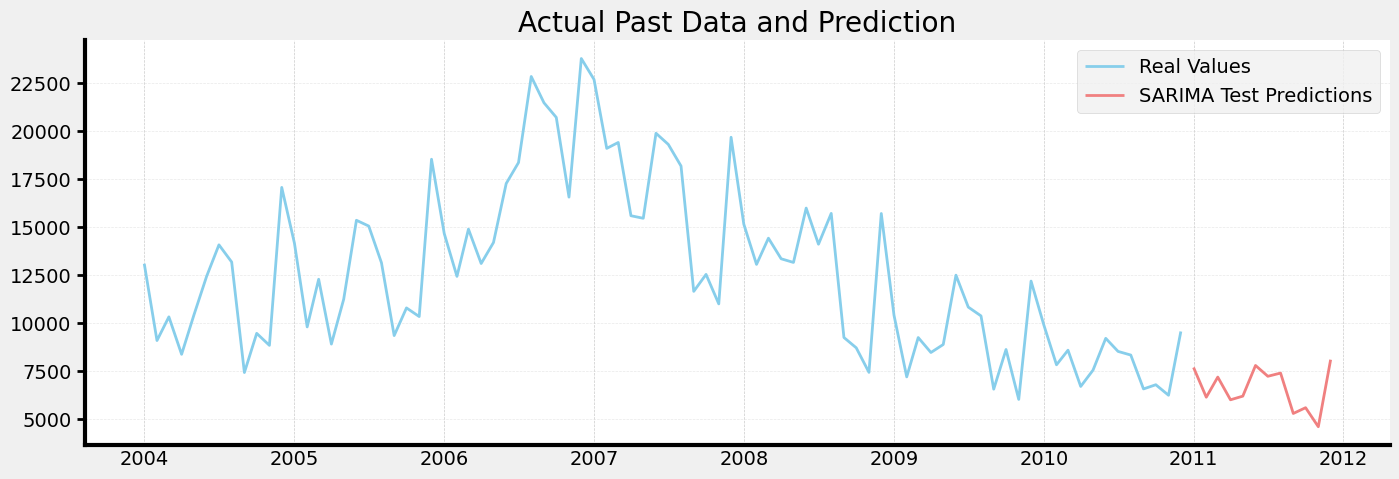

In [184]:
import matplotlib.pyplot as plt

# Assuming Baggage_mean contains the actual values and forecast contains the predicted values
plt.figure(figsize=(15, 5))

# Plot the actual data
plt.plot(Baggage_mean.index, Baggage_mean['Baggage'], label='Real Values', color='skyblue', linewidth=2)

# Plot the predicted data
plt.plot(forecast.index, forecast, label='SARIMA Test Predictions', color='lightcoral', linewidth=2)

# Set the background color to white
plt.gca().set_facecolor('white')

# Set the axis line colors and ticks
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Update y-axis settings
plt.gca().yaxis.set_tick_params(direction='out', length=6, width=2, colors='black',
                                grid_color='lightgrey', grid_alpha=0.5)

# Add legend and title
plt.legend()
plt.title('Actual Past Data and Prediction')

plt.show()


In [181]:
forecast

2011-01-01    7673.955584
2011-02-01    6126.598476
2011-03-01    7174.285004
2011-04-01    5991.382728
2011-05-01    6181.960527
2011-06-01    7778.856865
2011-07-01    7215.978678
2011-08-01    7383.401415
2011-09-01    5279.901489
2011-10-01    5579.705666
2011-11-01    4588.833681
2011-12-01    8080.067895
Freq: MS, Name: SARIMA Forecast, dtype: float64

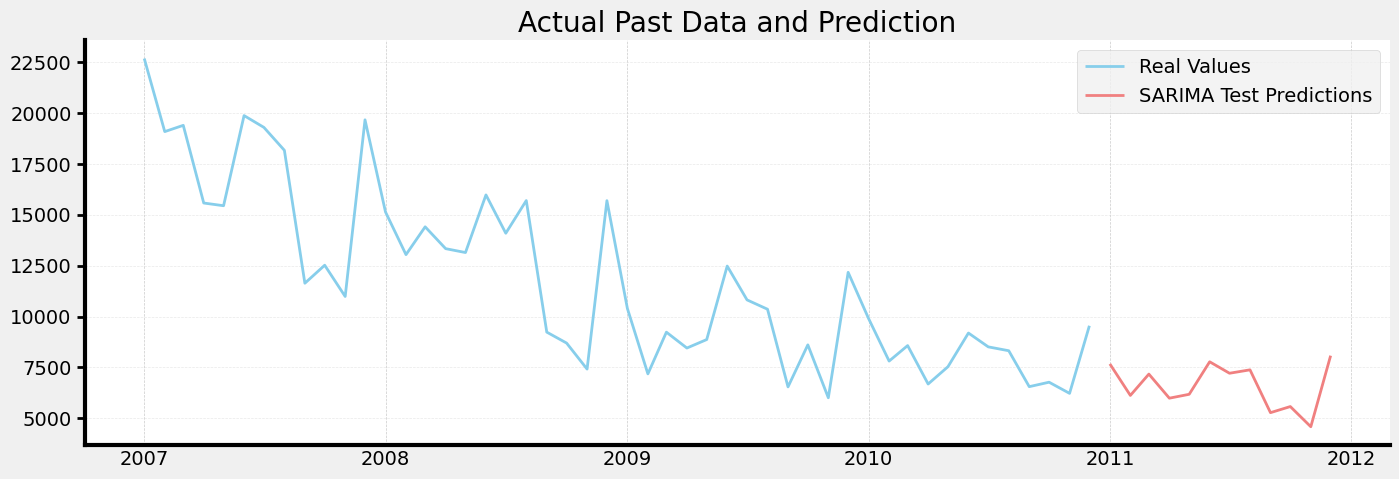

In [185]:
import matplotlib.pyplot as plt

# Define the colors
real_values_color = 'skyblue'
forecast_color = 'lightcoral'

# Create the figure
plt.figure(figsize=(15, 5))

# Plot the actual data (last 48 values)
plt.plot(Baggage_mean.index[-48:], Baggage_mean['Baggage'][-48:], label='Real Values', color=real_values_color, linewidth=2)

# Plot the forecast data
plt.plot(forecast.index, forecast, label='SARIMA Test Predictions', color=forecast_color, linewidth=2)

# Set the background color to white
plt.gca().set_facecolor('white')

# Set the axis line colors and ticks
plt.gca().spines['top'].set_color('none')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().tick_params(axis='x', colors='black')
plt.gca().tick_params(axis='y', colors='black')

# Add gridlines
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Update y-axis settings
plt.gca().yaxis.set_tick_params(direction='out', length=6, width=2, colors='black',
                                grid_color='lightgrey', grid_alpha=0.5)

# Add legend and title
plt.legend()
plt.title('Actual Past Data and Prediction')

plt.show()
